In [94]:
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
from collections import defaultdict
from network import Network
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d


def create_cluster_nodes(network: Network, n_clusters: int = 2):
    """
    Clusters nodes in the given network using DBSCAN.
    
    Args:
        network (Network): The network to be clustered.
        eps (float): The maximum distance between two samples for them to be considered in the same neighborhood.
        min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
        dict[int, list[Node]]: A dictionary mapping cluster IDs to lists of nodes in that cluster.
    """
    # Extract positions as a 2D array for clustering
    positions = np.array([[node.pos.x, node.pos.y] for node in network.nodes])

    # Run DBSCAN clustering
    kmeans = KMeans(n_clusters = n_clusters)
    clustering = kmeans.fit(positions)

    # Create a dictionary mapping clusters to nodes
    cluster_map = defaultdict(list)
    for node, cluster_label in zip(network.nodes, clustering.labels_):
        cluster_map[cluster_label].append(node)

    # Remove the noise cluster (label == -1) if present
    if -1 in cluster_map:
        del cluster_map[-1]
        
    

    # Calculate clusters centroids
    centroids = list()
    for cluster_nodes in cluster_map.values():
        positions = np.array([[x, y] for x, y in [(node.pos.x, node.pos.y) for node in cluster_nodes]])
        centroids.append(np.mean(positions, axis=0))

    # Voronoi tessellation
    centroids = np.array(centroids)[:, [1, 0]]
    vor = Voronoi(centroids)

    neighbors = {int(cluster_id): set() for cluster_id in cluster_map}

    # Iterate through ridge_points to find neighbors
    for point_pair in vor.ridge_points:
        cluster_a, cluster_b = point_pair
        neighbors[cluster_a].add(int(cluster_b))
        neighbors[cluster_b].add(int(cluster_a))
    
    for cluster_id, neighbor_set in neighbors.items():
        print(f"Cluster {cluster_id} neighbors: {neighbor_set}")
    

    voronoi_plot_2d(vor, ax=plt.gca(), show_points=False, show_vertices=False, line_colors='orange')
    
    y = [node.pos.x for node in network.nodes]
    x = [node.pos.y for node in network.nodes]

    plt.scatter(x, y, c = kmeans.labels_)
    plt.scatter([centroid[0] for centroid in centroids], [centroid[1] for centroid in centroids], c = 'red')
    for i, (cx, cy) in enumerate(centroids):
            plt.text(cx, cy, f"{i}", color="black", fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.xlim(-170, 190)
    plt.ylim(-50, 70)
    plt.show()

    return cluster_map, kmeans.inertia_, centroids

In [95]:
from simulator import Simulator
from network import Network
import numpy as np

from network import servers_csv_to_dict, pings_csv_to_dict

network = Network.from_dicts(pings_csv_to_dict("./../pings.csv"), servers_csv_to_dict("./../servers.csv"), fraction = 1)


Cluster 9 neighbors: {0, 2, 4, 8, 13}
Cluster 13 neighbors: {0, 2, 8, 9, 14}
Cluster 1 neighbors: {0, 5, 6, 10, 11}
Cluster 2 neighbors: {4, 8, 9, 13, 14}
Cluster 7 neighbors: {3, 5, 11, 12, 14}
Cluster 0 neighbors: {1, 6, 9, 11, 13, 14}
Cluster 3 neighbors: {4, 5, 14, 7}
Cluster 11 neighbors: {0, 1, 7, 10, 12, 14}
Cluster 14 neighbors: {0, 2, 3, 4, 7, 11, 13}
Cluster 8 neighbors: {9, 2, 13}
Cluster 10 neighbors: {1, 11, 12, 5}
Cluster 6 neighbors: {0, 1, 5}
Cluster 4 neighbors: {9, 2, 3, 14}
Cluster 5 neighbors: {1, 3, 6, 7, 10, 12}
Cluster 12 neighbors: {10, 11, 5, 7}


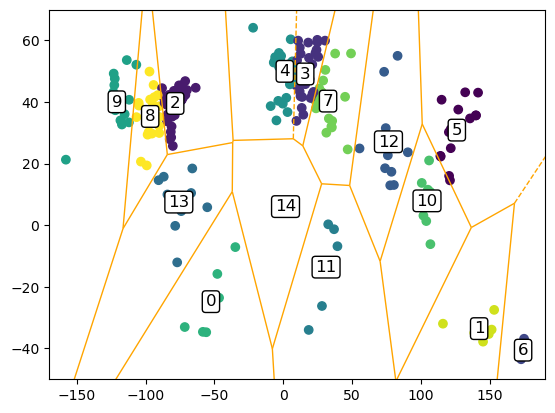

Cluster 9: [0, 50, 70, 125, 167, 238]
Cluster 13: [1, 21, 105, 107, 169, 218]
Cluster 1: [2, 13, 14, 15, 16, 18, 22, 40, 52, 68, 75, 78, 80, 81, 83, 89, 96, 97, 101, 102, 109, 110, 114, 124, 130, 136, 137, 138, 141, 145, 162, 171, 181, 184, 230, 233, 235, 239, 249, 250, 256]
Cluster 2: [3, 10, 20, 25, 26, 27, 28, 29, 32, 35, 45, 47, 60, 126, 127, 129, 147, 149, 150, 158, 160, 164, 170, 189, 190, 193, 195, 200, 202, 203, 206, 207, 210, 211, 212, 226, 246, 248, 264]
Cluster 7: [4, 7, 11, 17, 19, 43, 44, 48, 54, 58, 61, 63, 76, 77, 88, 91, 94, 153, 156, 157, 161, 185, 187, 188, 191, 196, 197, 198, 204, 208, 215, 216, 217, 223, 228, 229, 234, 236, 240, 241, 247, 260, 263, 291]
Cluster 0: [6, 72, 84, 95, 112, 113, 119, 159, 165, 180, 221, 224, 244, 261]
Cluster 3: [8, 59, 139]
Cluster 11: [9, 34, 62, 66, 67, 69, 87, 104, 116, 117, 154, 192, 194, 201, 205, 214, 227, 245, 251, 258]
Cluster 14: [12, 33, 39, 51, 55, 71, 90, 92, 106, 121, 122, 123, 135, 140, 142, 143, 144, 177, 231, 259]
Cluster

In [97]:
# Cluster nodes
clusters, inertia_v, centroids = create_cluster_nodes(network, n_clusters=15)

# Print cluster assignments
for cluster_id, cluster_nodes in clusters.items():
    print(f"Cluster {cluster_id}: {[node.node_id for node in cluster_nodes]}")